In [1]:
from pathlib import Path
from diffusion.time_scheduler import quadratic_beta_schedule
# from image_datasets.IXIdataset import IXIDataset
from image_datasets.capsSlicesADNI import get_ADNI_datasets
import torch
from torch.utils.data import DataLoader, Subset
from model.unet import Unet
from diffusion.diffusion import DiffusionModel
from torch.optim import Adam
from diffusion.sampler import sample
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from diffusion.utils import *
from utils.config import DiffusionConfig
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [2]:
def name_dim_mults(dim_mults):
    name = ''
    for dim in dim_mults:
        name+=str(dim)
    return name

## Load Dataset

### Dataset IXI

In [3]:
## Dataset IXI 
root = "./IXI-dataset-master/size64/"
dataset = IXIDataset(root, mode="train")

channels, image_size, _ = dataset[0]['image'].shape

batch_size = 20

<class 'NameError'>: name 'IXIDataset' is not defined

In [7]:
def return_loaders(train_size, test_size):
    train_set, val_set = train_test_split(dataset, train_size=train_size, test_size=test_size)

    train_set_batched = []
    for i in range(int(train_size_max/train_size)):
        train_set_batched.extend(train_set)
    train_set = train_set_batched
    
    print(len(train_set))
        
    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=False,
    )
    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
    )
    
    return train_loader, val_loader

### Dataset ADNI

In [6]:
## Dataset ADNI CN
datasets = get_ADNI_datasets('ADNI_AD_CN', img_size=128)

train_set = datasets["train_init"]
val_set = datasets["val_init"]

channels, image_size, _ = train_set[0]['image'].shape

batch_size = 20

In [7]:
random_train_indices = torch.randperm(len(train_set))[:20].tolist()

In [8]:
def return_loaders(train_size, test_size):
    #train_set, val_set = train_test_split(dataset, train_size=train_size, test_size=test_size)

    random_train_indices = torch.randperm(len(train_set))[:train_size].tolist()
    random_val_indices = torch.randperm(len(val_set))[:test_size].tolist()

    train_subset = Subset(train_set, random_train_indices)
    val_subset = Subset(val_set, random_val_indices)

    train_set_batched = []
    for i in range(int(train_size_max/train_size)):
        train_set_batched.extend(train_subset)
    train_subset = train_set_batched
    
    print(len(train_subset))
        
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=False,
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
    )
    
    return train_loader, val_loader

## Benchmark diffusion model

In [9]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32494MB, multi_processor_count=80)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_size_max = 400

train_sizes = [1,10,50,100,400] #1,10,50,100,
test_sizes = {1:1,10:10,50:50,100:100,400:40}

400


Start training!


  0%|          | 0/200 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.3.0+py3.11.5/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /gpfs7kro/gpfslocalsup/src/pub/anaconda-py3/2023.09/pytorch-gpu-2.3.0+py3.11.5+cuda-12.2/pytorch-2.3.0/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|##########| 200/200 [45:45<00:00, 13.73s/it]


1000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.3.0+py3.11.5/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 882.00 MiB. GPU  (Triggered internally at /gpfs7kro/gpfslocalsup/src/pub/anaconda-py3/2023.09/pytorch-gpu-2.3.0+py3.11.5+cuda-12.2/pytorch-2.3.0/aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
100%|##########| 10/10 [00:03<00:00,  3.19it/s]


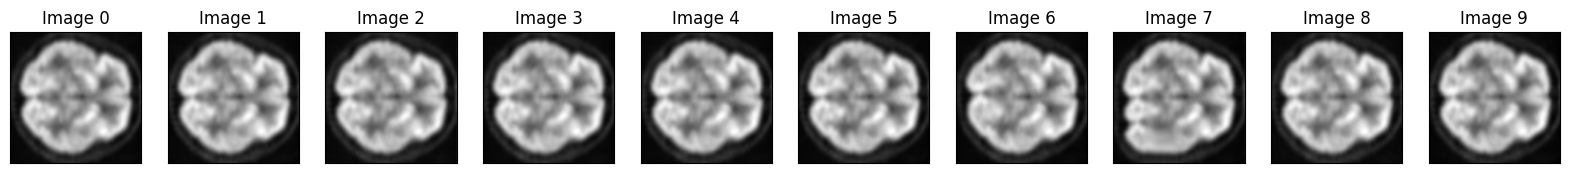

400


Start training!


100%|##########| 200/200 [44:53<00:00, 13.47s/it]


1000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|##########| 10/10 [00:04<00:00,  2.33it/s]


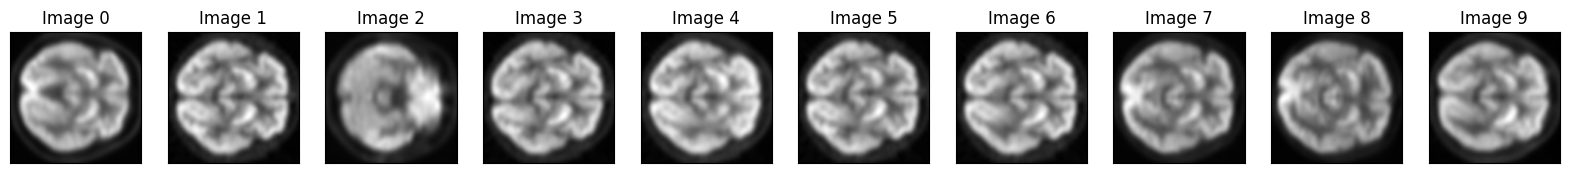

400


Start training!


100%|##########| 200/200 [44:55<00:00, 13.48s/it]


1000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|##########| 10/10 [00:22<00:00,  2.21s/it]


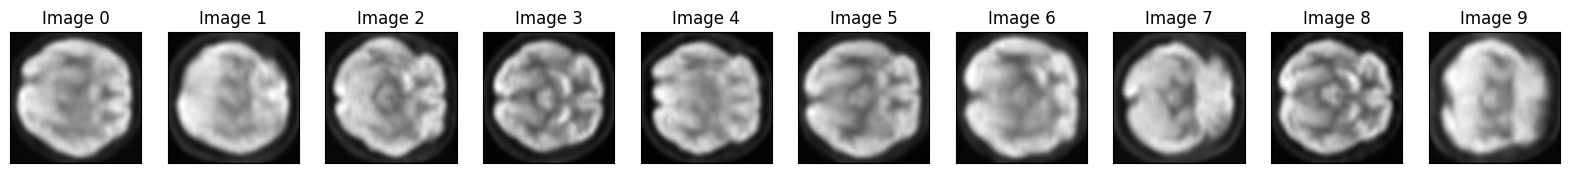

400


Start training!


100%|##########| 200/200 [45:54<00:00, 13.77s/it]


1000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|##########| 10/10 [00:43<00:00,  4.39s/it]


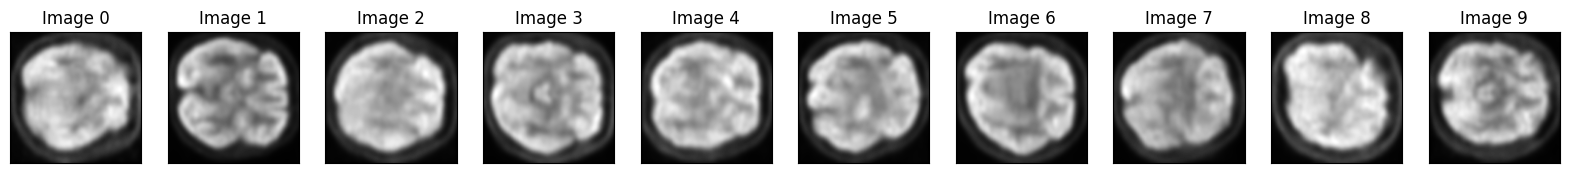

400


Start training!


 48%|####8     | 96/200 [21:30<23:19, 13.46s/it]

In [ ]:
for dim_mults in [(1,2,4,)]:#, (1,2,2,), (1,1,2,), (1,4,), (1,2,)]: #
    for timesteps in [1000]:#,1000,2000]:
        for epochs in [200]:#,300,600,900]:
            psnr_in_train_varying_dataset = np.zeros((len(train_sizes),10))
            psnr_out_train_varying_dataset = np.zeros((len(train_sizes),10))
            psnr_in_test_varying_dataset = np.zeros((len(train_sizes),10))
            psnr_out_test_varying_dataset = np.zeros((len(train_sizes),10))
            
            for idx_train_size, train_size in enumerate(train_sizes):
                
                train_loader, val_loader = return_loaders(train_size, test_sizes[train_size])
                #betas = quadratic_beta_schedule(timesteps, beta_start=0.00001, beta_end=0.01)
                diffusion_config = DiffusionConfig(
                    timesteps = timesteps,
                    beta_start = 0.00001,
                    beta_end = 0.01,
                    loss_type = 'huber',
                )

                model = Unet(
                    dim=image_size,
                    channels=channels,
                    dim_mults=dim_mults
                )

                model.to(device)

                nb_param = sum(p.numel() for p in model.parameters() if p.requires_grad)

                #ddpm = DiffusionModel(model, timesteps, betas, device, loss_type='huber')
                ddpm = DiffusionModel(model, diffusion_config, device)

                optimizer = Adam(model.parameters(), lr=3e-4)

                ddpm.train(epochs, optimizer, train_loader)

                # sample 10 images
                samples = sample(ddpm, image_size=image_size, batch_size=10, channels=channels)

                # check generalization
                psnr_in_train, psnr_out_train = ddpm.compute_psnr(train_loader, psnr_step=int(timesteps/10))
                psnr_in_val, psnr_out_val = ddpm.compute_psnr(val_loader, psnr_step=int(timesteps/10))

                #psnr_in_train_varying_dataset[idx_train_size] = np.array([x.numpy() for x in psnr_in_train])
                #psnr_out_train_varying_dataset[idx_train_size] = np.array([x.numpy() for x in psnr_out_train])

                #psnr_in_test_varying_dataset[idx_train_size] = np.array([x.numpy() for x in psnr_in_val])
                #psnr_out_test_varying_dataset[idx_train_size] = np.array([x.numpy() for x in psnr_out_val])

                psnr_in_train_varying_dataset[idx_train_size] = psnr_in_train
                psnr_out_train_varying_dataset[idx_train_size] = psnr_out_train

                psnr_in_test_varying_dataset[idx_train_size] = psnr_in_val
                psnr_out_test_varying_dataset[idx_train_size] = psnr_out_val

                start = 0
                end = -1

                fig, axs = plt.subplots(1, 10, figsize=(20, 8))
                for i in range(10):
                    axs[i].get_xaxis().set_visible(False)
                    axs[i].get_yaxis().set_visible(False)
                    axs[i].set_title(f"Image {i}")
                    axs[i].imshow(samples[-1][i].reshape(image_size, image_size, channels), cmap="gray")

                name_fig = "benchmark_images_gen/medical_UNet_synthesis_" + name_dim_mults(dim_mults)
                name_fig += "_attn_mdn_1_resblock_"+str(timesteps)+"_steps_"+str(epochs)+"_epochs"

                #fig.savefig(name_fig+".png")

                plt.show()
                
            plt.figure(figsize=(12,6))
            plt.subplot(121)
            plt.plot(psnr_in_train_varying_dataset[0], psnr_in_train_varying_dataset[0], linestyle='dashed', c='black')
            for idx_train_size, train_size in enumerate(train_sizes):
                plt.plot(psnr_in_train_varying_dataset[idx_train_size], psnr_out_train_varying_dataset[idx_train_size],\
                            label=str(train_size))
            plt.title('Train')
            plt.legend(loc='best')
            plt.subplot(122)
            plt.plot(psnr_in_train_varying_dataset[0], psnr_in_train_varying_dataset[0], linestyle='dashed', c='black')
            for idx_train_size, train_size in enumerate(train_sizes):
                plt.plot(psnr_in_test_varying_dataset[idx_train_size], psnr_out_test_varying_dataset[idx_train_size],\
                            label=str(train_size))
            plt.title('Test')
            plt.legend(loc='best')
            plt.show()

In [9]:
psnr_in_train

array([56.014668 , 27.380293 , 19.959223 , 15.13296  , 11.398989 ,
        8.1830015,  5.171503 ,  2.143975 , -1.0880702, -4.7053714],
      dtype=float32)

In [ ]:
torch.save(ddpm.state_dict(), name_dim_mults(dim_mults)+"attn_mdn_1_resblock_"+str(timesteps)+"_steps_"+str(epochs)+"_epochs")

In [ ]:
for x in train_loader:
    plt.imshow(x['image'][0,0], cmap='nipy_spectral', vmin=-1, vmax=1)
    plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(psnr_in_train_varying_dataset[0], psnr_in_train_varying_dataset[0], linestyle='dashed', c='black')
for idx_train_size, train_size in enumerate(train_sizes):
    plt.plot(psnr_in_train_varying_dataset[idx_train_size], psnr_out_train_varying_dataset[idx_train_size],\
                label=str(train_size))
plt.title('Train')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(psnr_in_train_varying_dataset[0], psnr_in_train_varying_dataset[0], linestyle='dashed', c='black')
for idx_train_size, train_size in enumerate(train_sizes):
    plt.plot(psnr_in_test_varying_dataset[idx_train_size], psnr_out_test_varying_dataset[idx_train_size],\
                label=str(train_size))
plt.title('Test')
plt.legend(loc='best')
plt.show()

In [17]:
"""torch.save(psnr_in_train_varying_dataset, 'psnr_in_train_varying_dataset')
torch.save(psnr_out_train_varying_dataset, 'psnr_out_train_varying_dataset')
torch.save(psnr_in_test_varying_dataset, 'psnr_in_test_varying_dataset')
torch.save(psnr_out_test_varying_dataset, 'psnr_out_test_varying_dataset')"""